## GAT IMPLEMENTATION

In [1]:
TOTAL_CLIENTS = 610
LR=0.01
INPUT_CHANNELS = 256
HIDDEN_CHANNELS = 256
EPOCHS = 3 #3
CLIENTS_COUNT= 128 #128
ROUNDS = 30

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch.autograd import Variable
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import random

In [3]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hidden_channels = INPUT_CHANNELS
        self.input_channels = HIDDEN_CHANNELS
        self.headsv1 = 1
        self.headsv2 = 1
 
        self.conv1 = GATConv(in_channels=self.input_channels, out_channels=self.hidden_channels, 
                               heads=self.headsv1, dropout=0.2)
#         self.conv2 = GATv2Conv(in_channels=self.hidden_channels*self.headsv1, out_channels=self.hidden_channels,
#                              heads=self.headsv2, dropout=0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  
        x_in = Variable(x, requires_grad=True)
        x = F.dropout(x_in, p=0.2, training=self.training) 
        x = self.conv1(x, edge_index)                   
        x = F.elu(x)
        
        y = x[0,:] * x[1:,:]
        y = torch.sum(y, dim=1, dtype=float)
        y = F.relu(y)
        y.retain_grad()
        return x_in, y
    
    

## Federated Pipeline

In [4]:
class FederatedNetwork:
    def __init__(self, device, state_dict):
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.initialize_model(device, state_dict)
        
    def initialize_model(self, device, state_dict):
        self.model = GAT().to(device)
        if state_dict != None:
            self.model.load_state_dict(state_dict)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LR, weight_decay=5e-4)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=0)
        self.criterion = nn.MSELoss()  #Square it later
        

In [5]:
class Client(FederatedNetwork):
    def __init__(self, client_id, rated_items, items_embeddings, device, state_dict):
        self.items_embeddings = dict()
        self.user_embedding = None
        self.items_rated = None
        self.items_embeddings_grad = None
        self.id = client_id
        self.graph_data = None
        self.y = None
        self.all_embeddings = None
        self.initialize_client(rated_items, items_embeddings, device)
        super().__init__(device, state_dict)
        
    def initialize_client(self, rated_items, items_embeddings, device):
        self.initialize_rated_items(rated_items)
        self.initialize_embeddings(items_embeddings)
        self.initalize_graph(device)
    
    def update_weights(self, weights):
        self.model.load_state_dict(weights)
    
    def initialize_rated_items(self, rated_items):
        self.items_rated = rated_items
        
    def initialize_embeddings(self, items_embeddings):
        self.user_embedding = torch.nn.init.xavier_uniform_(torch.empty(1, 256))
        self.update_item_embeddings(items_embeddings)
        
    def update_item_embeddings(self, items_embeddings):
        self.all_embeddings = items_embeddings
        self.items_embeddings = items_embeddings[items_embeddings['movieId'].isin(self.items_rated["movieId"])]
            
            
    def get_items_embeddings_grad(self):
        return self.items_embeddings_grad
    
    def get_item_embeddings(self):
            return self.all_embeddings
    
    def generate_graph_from_data(self):
        list_a = [0]*(len(self.items_rated)) + [i for i in range(1, len(self.items_rated)+1)]
        list_b = [i for i in range(1, len(self.items_rated)+1)]+[0]*(len(self.items_rated)) 
        edge_index = torch.tensor([list_a,
                           list_b], dtype=torch.long)
        x = [self.user_embedding.numpy()[0], ]
        item_emb = self.items_embeddings['embeddings'].values
        x += [item_emb[i] for i in range(len(item_emb))] 
        x = torch.tensor(np.array(x), dtype=torch.float)
        
        y = torch.tensor(self.items_rated['rating'].values)
        
        return x, y, edge_index
     
    def initalize_graph(self, device):
        x, y, edge_index = self.generate_graph_from_data()
        self.graph_data = Data(x=x, edge_index=edge_index)
        self.graph_data = self.graph_data.to(device)
        self.y = y
        
    def item_count(self):
        return len(self.items_rated)
        
    
    def train_model(self, lr=LR):
#         optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.0)
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=5e-4)
        self.model.train()
        
        for epoch in range(EPOCHS):
            self.optimizer.zero_grad()
            x, out = self.model(self.graph_data)
            loss = torch.sqrt(self.criterion(out, self.y))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.optimizer.step()  
            self.graph_data.x -= lr*x.grad
#         print(f"{self.id} Loss: ", loss)
            
        self.__update_embeddings_from_model(self.graph_data.x)
        return loss
    
    def __update_embeddings_from_model(self, graph_x):
        self.user_embedding = graph_x[0]
        for i in range(1, len(graph_x)):
            index = self.all_embeddings.index[self.all_embeddings['movieId'] == self.items_embeddings.iloc[i-1]['movieId']]
            self.items_embeddings.iat[i-1, 1] =  graph_x[i]
            self.all_embeddings.iat[index[0], 1] =  graph_x[i].numpy()
          
    
    def evaluate_model(self, data=None):
        if data == None:
            data = self.graph_data
        self.model.eval()
        _, pred = self.model(data)
        pred = torch.round(2*pred.data)/2

#         print("\n\nLocal:\nActual: ", self.y[:10])
#         print("Predicted: ", pred[:10])

        correct = float(pred.eq(self.y).sum().item())
        acc = correct / len(self.y)
#         print('Client', self.id,' Local Accuracy: {:.4f}'.format(acc))
        return acc
    
    def evaluate_global(self, model):
        data = self.graph_data
        model.eval()
        _, pred = model(data)
        pred = torch.round(pred.data)
#         print("\n\nClient: ", self.id)
#         print("Global\nActual: ", self.y[:10])
#         print("Predicted: ", pred[:10])

        correct = float(pred.eq(self.y).sum().item())
        acc = correct / len(self.y)
#         print('Client', self.id,' Global Accuracy: {:.4f}'.format(acc))

        return acc
    
    def __str__(self):
        return repr(self.items_rated)
        

In [6]:
class Server(FederatedNetwork):
    def __init__(self, items, device, empty):
        super().__init__(device, empty)
        self.items = items        
        self.items_embeddings = None
    
    def generate_item_embeddings(self):
        embeddings = torch.nn.init.xavier_uniform_(torch.empty(self.items.shape[0], 256))
        df = pd.DataFrame({"id": np.arange(1, embeddings.shape[0]+1)})
        df["embeddings"] = list(embeddings.numpy())
        self.items_embeddings = pd.concat([self.items['movieId'], df["embeddings"]], axis=1)
        return self.items_embeddings
    
    def get_item_embeddings(self):
        return self.items_embeddings   
        

In [7]:
class Driver:

    def __init__(self, device, state_dict):
        self.server = None
        self.clients = None
        self.ratings_data = None
        self.initialize_server(device)
        self.initialize_clients(device, state_dict)

    def initialize_clients(self, device, state_dict, client_count=CLIENTS_COUNT):
        self.ratings_data = pd.read_csv('ml-latest-small/ratings.csv')
        self.ratings_data.drop('timestamp', inplace=True, axis=1)
        clients = random.sample(range(1, TOTAL_CLIENTS+1), client_count)
        self.clients = []
        for i in range(0, client_count):
            id = clients[i]
            client_i = Client(id, self.ratings_data[self.ratings_data['userId'] == id], self.server.get_item_embeddings(), device, state_dict)
            self.clients.append(client_i)
            
#         self.clients = pd.DataFrame(self.clients, columns=['clients'])
        return self.clients
    
    def initialize_server(self, device):
        items = pd.read_csv('ml-latest-small/movies.csv')
        self.server = Server(items, device, None)
        embeddings = self.server.generate_item_embeddings()
        return embeddings
        
    def get_embeddings(self):
        return self.server.get_item_embeddings()


## Driver Code for Training on Client 1

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = GAT().to(device)
driver_obj = Driver(device, global_model.state_dict())
print(driver_obj.clients[0].graph_data)

Data(x=[21, 256], edge_index=[2, 40])


In [8]:

lost = []

for training_round in range(ROUNDS):
    total_items = 0
    weights = []
    embeddings = [] 
    items_rated = []
    losses = []
    #TRAIN THE NETWORK
    for client in driver_obj.clients:
        losses.append(client.train_model())
        total_items += client.item_count()
        weights.append(client.model.state_dict())
        embeddings.append(client.get_item_embeddings())
        items_rated.append(client.item_count())
    
    
    #UPDATE GLOBAL MODEL

    #WEIGHTED AVERAGE: 
    new_parameters = global_model.state_dict()
    for key in new_parameters:
        new_parameters[key] = weights[0][key]
        for i in range(1, len(weights)):
            new_parameters[key] += weights[i][key]*(items_rated[i])
        new_parameters[key]/=float(total_items)
        

    global_model.load_state_dict(new_parameters)
    
    
    #UPDATE GLOBAL EMBEDDINGS    
    df = pd.concat(i for i in embeddings)
#     print(df.loc[df['movieId'] == 1])
    global_embeddings = df.groupby(by="movieId", as_index=False).mean()
#     print("Mean Embeddings:\n", global_embeddings)
    global_embeddings.reset_index()
#     print(global_embeddings['movieId'])
    
    # EVALUATE
    acc = 0
    l_acc = 0
    for client in driver_obj.clients:
        acc += client.evaluate_global(global_model)
        l_acc += client.evaluate_model()
    loss = 0
    for i in losses:
        loss += i
    loss/=CLIENTS_COUNT
    
    
    print("\n\nRound: ", training_round)
    print('Global Accuracy: {:.4f}'.format(acc/CLIENTS_COUNT))
    print('Local Accuracy: {:.4f}'.format(l_acc/CLIENTS_COUNT))
    print('Loss: ', loss.item())
    lost.append(loss.item())

    
    # UPDATE LOCAL CLIENTS
    for client in driver_obj.clients:
        client.update_weights(global_model.state_dict())
        client.update_item_embeddings(global_embeddings)




Round:  0
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.709170740008659


Round:  1
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7091840737710653


Round:  2
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7085361750865276


Round:  3
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.707897505428661


Round:  4
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.70620070062171


Round:  5
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7070726160717005


Round:  6
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7057395363581396


Round:  7
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7030389100415273


Round:  8
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.703744909943444


Round:  9
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7028184905181827


Round:  10
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.7026466953968966


Round:  11
Global Accuracy: 0.0000
Local Accuracy: 0.0000
Loss:  3.

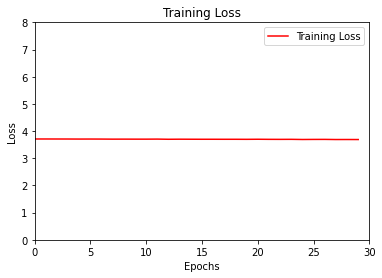

In [9]:
#PRINT LOSS GRAPH
import matplotlib.pyplot as plt
epochs = range(ROUNDS)
plt.plot(epochs, lost, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, ROUNDS])
plt.ylim([0, 8])
plt.legend()
plt.show()

- Create 2 datasets for each client one for validation and one for training
- Client should only update gradients of the updated items, this way validation set item's gradients won't get resent 
- Each client should keep same data split for all training rounds


- In each round, server selects a subset of 128 clients from total clients. 

- During each epoch of the round, client should have created mini-bacthes of data on which model is trained (all mini-batches iterated in one epoch) [and they are averaged in the end of epoch and gradients of model are updated]

- After a round, each client sends their gradients, server averages them and sends them back to each client.

- Validate the models on every client on the network


#### FedGNN Paper Notes:

- In our experiments, we use graph attention network (GAT) [28] as the GNN model, 

- and use dot product to implement the rating predictor. 

- The user and item embeddings and their hidden representations learned by graph neural networks are 256-dim. 

- The gradient clipping threshold 𝛿 is set to 0.1

- The number of users used in each round of model training is 128, 

- and the total number of epoch is 3. 

- The ratio of dropout [25] is 0.2. 

- Its learning rate is 0.01. 

- The metric used in our experiments is rooted mean square error (RMSE), 

- FedAVG is used as aggregator



- **TODO** The splits of datasets are the same as those used in [2], and these hyperparameters are selected accordingo to the validation performance.

- **TODO** Mini-batches used on local clients for training

- **TODO** Randomize clients subset in each round. 

- **TODO** The round threshold 𝑇 is 2 for using neighboring users embeddings. 

- **TODO** the strength of Laplacian noise in the LDP module is set to 0.2 to achieve 1-differential privacy. 

- **TODO** The number of pseudo interacted items is set to 1,000.

- **TODO** SGD is selected as the optimization algorithm 

- **TODO** We report the average RMSE scores over the 10 repetitions.